In [551]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
from keras.callbacks import History, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
import pickle
from sklearn.decomposition import PCA

In [552]:
data = pd.read_csv("smiles01.csv")
top_300 = df.nlargest(250, 'Energy')
smiles_train, smiles_test = train_test_split(top_300, random_state=42)
smiles_test.shape

(63, 2)

In [553]:
smiles_train.apply

<bound method DataFrame.apply of                      smiles    Energy
194  C1=CC=C2C(=C1)C=CC=C2O   298.160
122                     CCN    25.000
306                   CNCCO    25.000
345           CCCCCCCCCCCCO     9.000
28        CC(C)[N+](=O)[O-]    25.000
..                      ...       ...
19                   C(=O)O    25.000
279                CCCC(C)C  3245.000
357               CCN(CC)CC   248.000
384            C(#N)N=C(N)N    25.000
15                    CCCCO    36.111

[187 rows x 2 columns]>

In [554]:
smiles_train.shape

(187, 2)

data

In [555]:
len(data)

522

In [556]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(len(charset), embed)

43 88


In [557]:
charset

{'!',
 '#',
 '(',
 ')',
 '+',
 '-',
 '.',
 '/',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '=',
 '@',
 'A',
 'B',
 'C',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'N',
 'O',
 'P',
 'S',
 'T',
 'Z',
 '[',
 '\\',
 ']',
 'a',
 'b',
 'e',
 'i',
 'l',
 'n',
 'r'}

In [558]:
#SMILES must be vectorized to one-hot encoded arrays.
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train['smiles'].values)

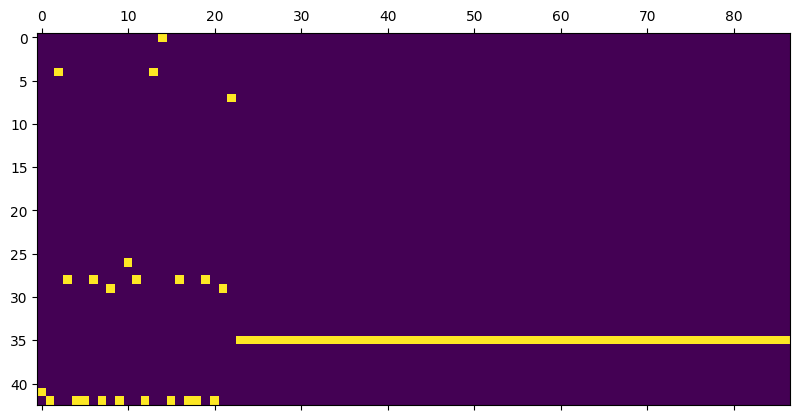

In [559]:
X_train, Y_train = vectorize(smiles_train['smiles'].values)
X_test,Y_test = vectorize(smiles_test['smiles'].values)
plt.matshow(X_train[0].T)

In [560]:
len(X_test)

63

In [561]:
smiles_train['smiles'].iloc[0]

'C1=CC=C2C(=C1)C=CC=C2O'

In [562]:
	
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])


'!C1=CC=C2C(=C1)C=CC=C2OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [563]:
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [564]:
#enconder
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [565]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )

In [566]:
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [567]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [568]:
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 87, 43)]             0         []                            
                                                                                                  
 lstm_34 (LSTM)              [(None, 64),                 27648     ['input_43[0][0]']            
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 concatenate_5 (Concatenate  (None, 128)                  0         ['lstm_34[0][1]',             
 )                                                                   'lstm_34[0][2]']      

In [569]:
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

In [570]:
opt=Adam(lr=0.005) 
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [571]:
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 3.7456 - val_loss: 3.7004 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 109ms/step - loss: 3.7012 - val_loss: 3.6546 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 105ms/step - loss: 3.6555 - val_loss: 3.6062 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 103ms/step - loss: 3.6072 - val_loss: 3.5535 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 106ms/step - loss: 3.5547 - val_loss: 3.4945 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 110ms/step - loss: 3.4958 - val_loss: 3.4266 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 111ms/step - loss: 3.4282 - val_loss: 3.3470 - lr: 0.0010
Epoch 8/200
1/1 [==============================] - 0s 111ms/step - loss: 3.3488 - val_loss: 3.2518 - lr: 0.0010
Epoch 9/200
1/1 [==============================] - 0s 108ms/step - loss: 3.2539 - val_loss: 3.1361 - lr: 0.

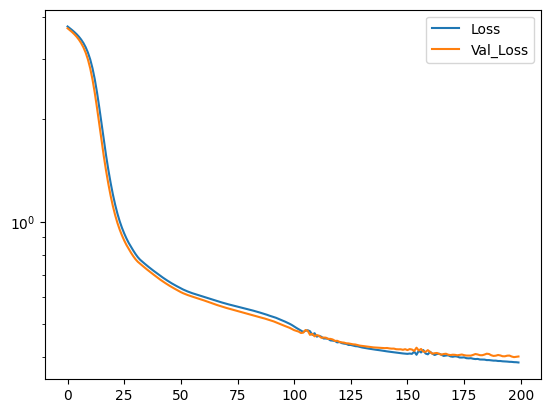

In [572]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [573]:
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(True, pred)

1/1 [==============================] - 0s 302ms/step
True CCCCCCCCCCCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 18ms/step
True CCCCCCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 16ms/step
True CCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 15ms/step
True CCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 15ms/step
True CCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 16ms/step
True CCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 17ms/step
True CCCCCCCCCCCCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [574]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)

In [575]:
smiles_to_latent_model.save("fuel_smile2lat.h5")

/home/mariochiaparini/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [576]:
latent_input = Input(shape=(latent_dim,))
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("fuel_smile2lat.h5")

In [577]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [578]:
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("fuel_smile2lat.h5")

In [579]:
x_latent = smiles_to_latent_model.predict(X_test)
len(x_latent[0:1])

2/2 [==============================] - 0s 7ms/step


1

1/1 [==============================] - 0s 15ms/step
[ 5  4 58 57  3 41 52 40  9 42 44  1 18 17 28 23 47 12 60  6]
394                           CCOC
33                             CNC
324                       C1CCCCC1
252                  C1CCC(=O)NCC1
118                            CCC
496                           [Ca]
214                    C1COC(=O)O1
86             COC(=O)C1=CC=CC=C1O
13                          CCCC=O
25                 CC1=CC(=CC=C1)O
204                 CC1=CC=CC=C1Cl
65                    CC1=CC=CC=C1
376               COC1=CC=C(C=C1)O
302                          CCCCC
385                          C=C=O
507    C/C=C/1\C[C@H]2C[C@@H]1C=C2
511    C/C=C/1\C[C@H]2C[C@@H]1C=C2
201       COC(=O)C1CCC(CC1)C(=O)OC
119                           CC#C
67           COC1=C(C=CC(=C1)C=O)O
Name: smiles, dtype: object


ValueError: Could not save to JPEG for display

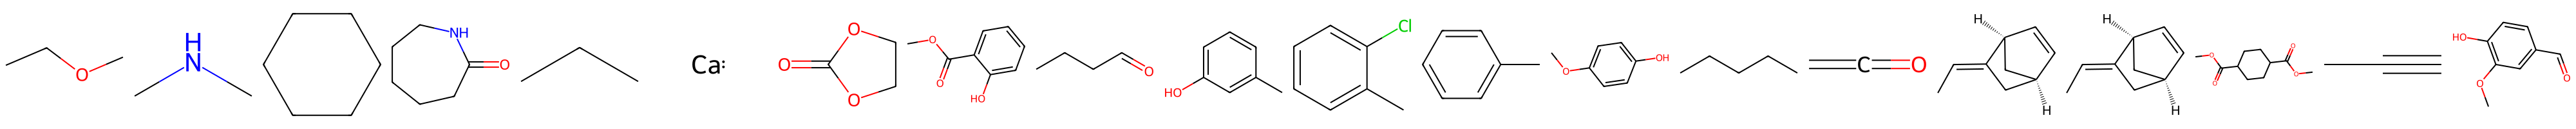

In [580]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:20])
print (smiles_test['smiles'].iloc[sorti[0:20]])
Draw.MolsToImage(smiles_test['smiles'].iloc[sorti[0:20]].apply(Chem.MolFromSmiles))

ValueError: Could not save to JPEG for display

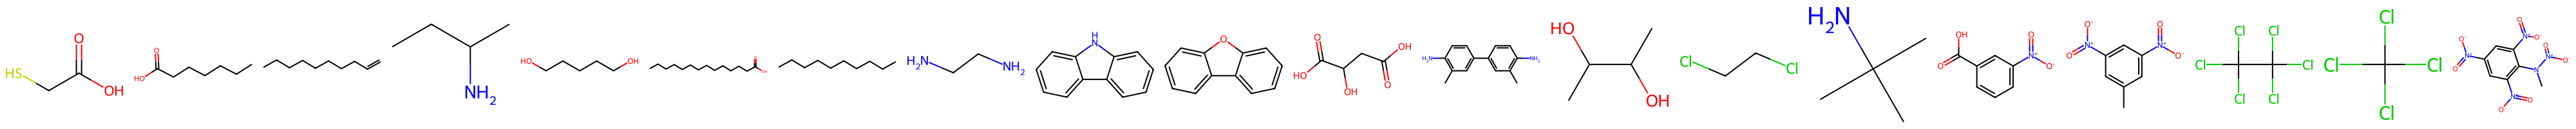

In [581]:
Draw.MolsToImage(smiles_test['smiles'].iloc[sorti[-20:]].apply(Chem.MolFromSmiles))

In [ ]:
logp = smiles_test['Energy']

In [ ]:
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))


In [ ]:
x_train_latent = smiles_to_latent_model.predict(X_train)

In [ ]:
logp_train = smiles_train['Energy']

In [ ]:
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

In [ ]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=400, callbacks = [rlr])


In [ ]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test)
plt.scatter(logp_train, logp_pred_train)
plt.legend()

In [ ]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    #samplevec = np.zeros((1,1,22))
    #samplevec[0,0,startidx] = 1
    num_chars = len(char_to_int)
    samplevec = np.zeros((1, 1, num_chars))
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [ ]:
def latent_to_smiles(latent):
    # Decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0], states[1]])
    
    # Prepare the input char
    startidx = char_to_int["!"]
    num_chars = len(char_to_int)
    samplevec = np.zeros((1, 1, num_chars))
    samplevec[0, 0, startidx] = 1
    smiles = ""
    
    # Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1, 1, num_chars))
            samplevec[0, 0, sampleidx] = 1
        else:
            break
            
    return smiles

In [ ]:
smiles = latent_to_smiles(x_latent[0:1])

In [ ]:
len(x_latent[0:1])

In [ ]:
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print(smiles)
        wrong = wrong + 1

In [ ]:
print("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))

In [514]:
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)

In [515]:
for r in ratios:
    #print r
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)

1/1 [==============================] - 0s 10ms/step


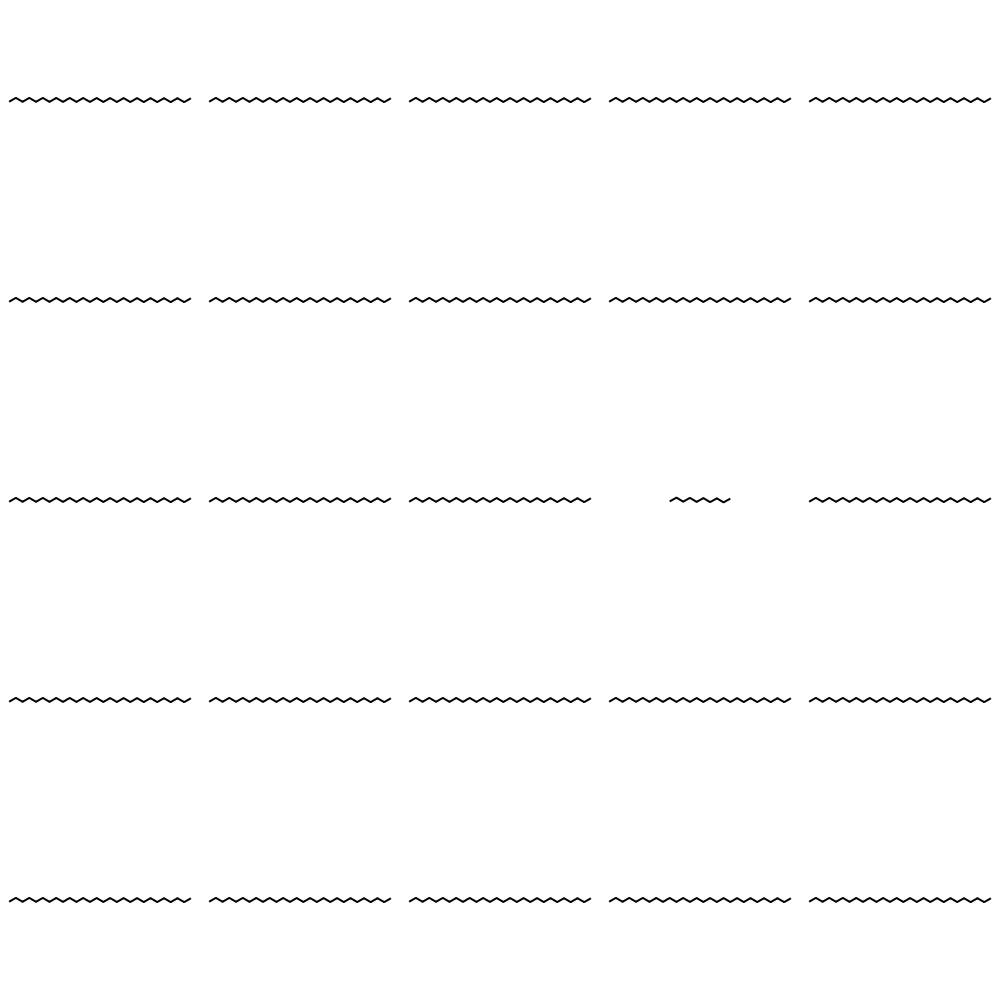

In [516]:
Draw.MolsToGridImage(mols1, molsPerRow=5)

1/1 [==============================] - 0s 10ms/step


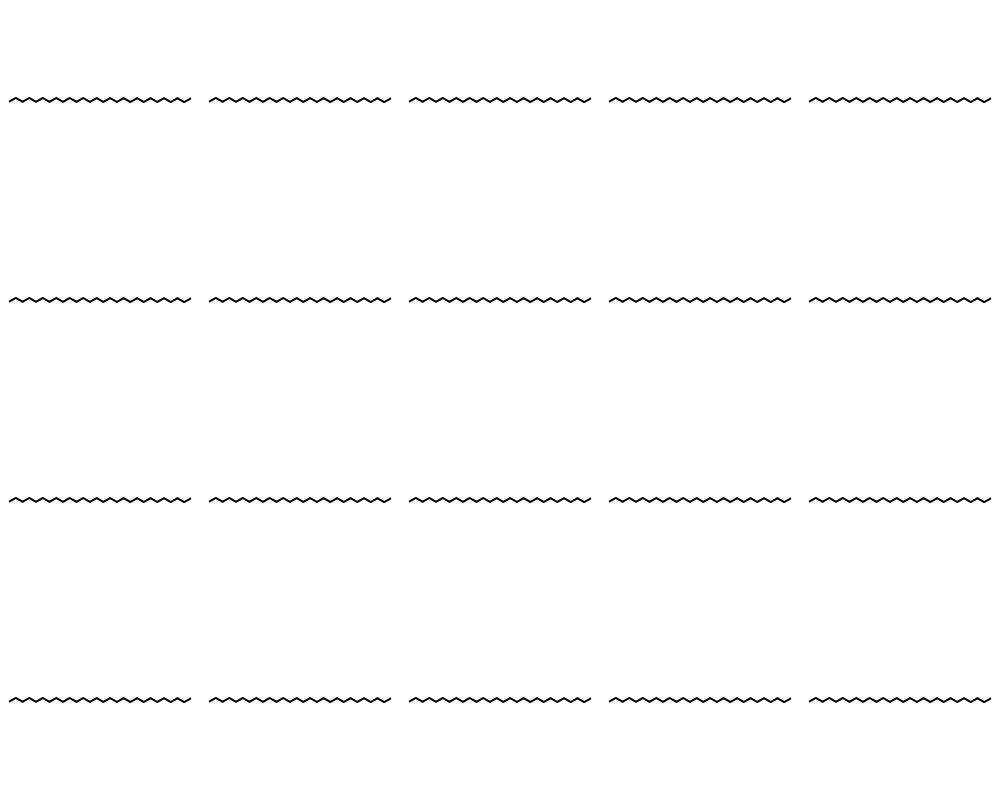

In [517]:
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)